<a href="https://colab.research.google.com/github/MJMortensonWarwick/data_engineering_for_data_scientists/blob/main/2_1_DAG_Orchestration_Emulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.1 DAG Orcherstration Emulator
This Notebook is a somewhat fun attempt to demo how an orchestrator works. In the out-of-the-box setting the DAG has been incorrectly setup as below (don't fix it yet! Just run the code.):

In [13]:
my_pipeline_order = [
    "load_warehouse",
    "authenticate",
    "extract_data",
    "quality_check",
    "encrypt_pii"
]

Using this pipeline we will try (and fail) to run the orchestration (simulation mode only):

Analysing Pipeline Order: ['load_warehouse', 'authenticate', 'extract_data', 'quality_check', 'encrypt_pii']...



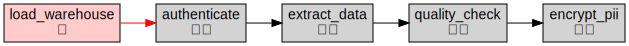

In [15]:
import graphviz
from IPython.display import display

# ==========================================
# PLEASE DON'T EDIT THIS PART!!
# ==========================================

def get_pipeline_status(pipeline):
    """
    Runs the logic check and returns a dictionary of node statuses.
    Returns: { 'step_name': 'success' | 'error' | 'warning' | 'skipped' }
    """
    state = {"has_auth": False, "has_data": False, "is_safe": False, "is_clean": False}
    status_map = {}
    failed = False

    for step in pipeline:
        if failed:
            status_map[step] = "skipped"
            continue

        if step == "authenticate":
            state["has_auth"] = True
            status_map[step] = "success"

        elif step == "extract_data":
            if not state["has_auth"]:
                status_map[step] = "error"
                failed = True
            else:
                state["has_data"] = True
                status_map[step] = "success"

        elif step == "quality_check":
            if not state["has_data"]:
                status_map[step] = "error"
                failed = True
            else:
                state["is_clean"] = True
                status_map[step] = "success"

        elif step == "encrypt_pii":
            if not state["has_data"]:
                status_map[step] = "error"
                failed = True
            else:
                state["is_safe"] = True
                status_map[step] = "success"

        elif step == "load_warehouse":
            if not state["has_data"]:
                status_map[step] = "error"
                failed = True
            elif not state["is_clean"]:
                status_map[step] = "warning" # It runs, but it's dangerous
            elif not state["is_safe"]:
                status_map[step] = "error" # Hard fail for legal reasons
                failed = True
            else:
                status_map[step] = "success"

    return status_map

# ==========================================
# DAG Visualisation
# ==========================================

def render_dag(pipeline, status_map):
    dot = graphviz.Digraph(comment='Data Pipeline')
    dot.attr(rankdir='LR') # Left to Right

    # Airflow-style node colors
    colors = {
        "success": "#90EE90", # Light Green
        "error": "#FFCCCB",   # Light Red
        "warning": "#FFFFE0", # Light Yellow
        "skipped": "#D3D3D3"  # Grey
    }

    # 1. Create Nodes
    for step in pipeline:
        status = status_map.get(step, "skipped")
        color = colors.get(status, "white")

        # Add label with status icon
        icon = "✅" if status == 'success' else "❌" if status == 'error' else "⚠️" if status == 'warning' else "⏭️"
        label = f"{step}\n{icon}"

        dot.node(step, label, shape="box", style="filled", fillcolor=color, fontname="Helvetica")

    # 2. Create Edges (The Flow)
    # We link step[i] -> step[i+1] based on the user's list
    for i in range(len(pipeline) - 1):
        u = pipeline[i]
        v = pipeline[i+1]

        # Color the edge red if the source failed
        edge_color = "red" if status_map[u] == "error" else "black"
        dot.edge(u, v, color=edge_color)

    display(dot)

# ==========================================
# EXECUTION
# ==========================================

print(f"Analysing Pipeline Order: {my_pipeline_order}...\n")
statuses = get_pipeline_status(my_pipeline_order)
render_dag(my_pipeline_order, statuses)

As we can see - we failed on step one. Re-order the operations below and then run Cell 2 to get a successful flow!

In [3]:
my_pipeline_order = [
    "load_warehouse",
    "authenticate",
    "extract_data",
    "quality_check",
    "encrypt_pii"
]